#### **LAB3 - task4**

#### **LAB1**

Task 1

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

wandb.login()

# Ustawienia
batch_size = 64
learning_rate = 0.001
num_epochs = 5

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
    },
)

# Przekształcenia danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Wczytywanie danych
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Definicja modelu
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Przekształcenie do wektora
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicjalizacja modelu, kryterium i optymalizatora
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trenowanie modelu
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
          # Obliczanie dokładności
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        wandb.log({"accuracy": acc, "loss": loss})
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testowanie modelu
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch [1/5], Loss: 0.4662
Epoch [2/5], Loss: 0.3230
Epoch [3/5], Loss: 0.3727
Epoch [4/5], Loss: 0.1801
Epoch [5/5], Loss: 0.3285
Accuracy of the model on the test images: 86.88%


Task 2

Epoch [1/10], Loss: 0.0582
Epoch [2/10], Loss: 0.0488
Epoch [3/10], Loss: 0.0623
Epoch [4/10], Loss: 0.0453
Epoch [5/10], Loss: 0.0523
Epoch [6/10], Loss: 0.0500
Epoch [7/10], Loss: 0.0472
Epoch [8/10], Loss: 0.0486
Epoch [9/10], Loss: 0.0517
Epoch [10/10], Loss: 0.0401


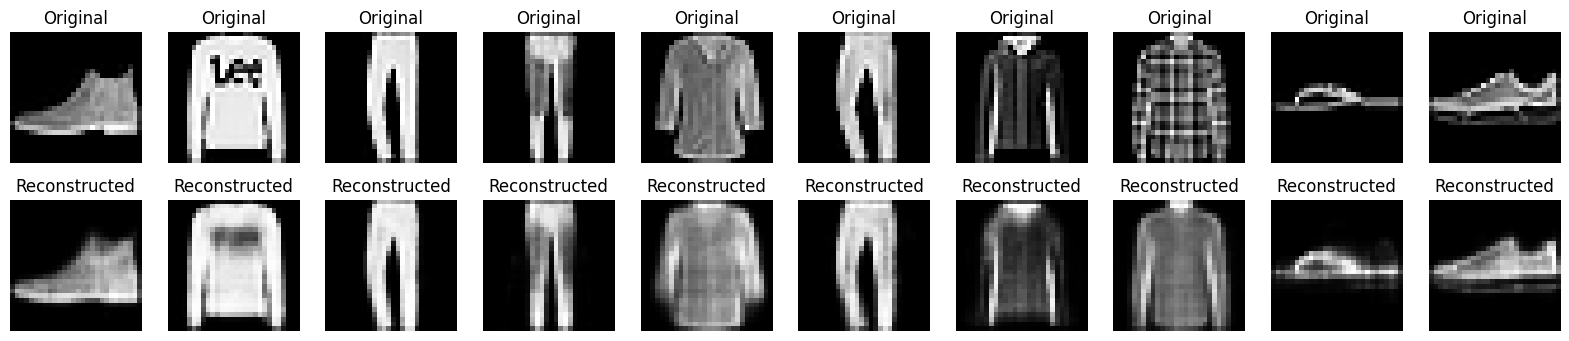

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input layer
            nn.ReLU(),
            nn.Linear(128, 64),       # Hidden layer
            nn.ReLU(),
            nn.Linear(64, 32)         # Bottleneck layer
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),  # Output layer
            nn.Tanh()                 # Use Tanh to normalize the output between -1 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)  # Reshape back to image format

# Initialize model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the Autoencoder
for epoch in range(num_epochs):
    for images, _ in train_loader:  # We don't need labels for the autoencoder
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the Autoencoder
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    reconstructed_images = model(test_images)

# Plotting original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].view(28, 28).numpy(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].view(28, 28).numpy(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()


Task 3

In [ ]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

model = bundle.get_model().to(device)
# print(model.__class__)



Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

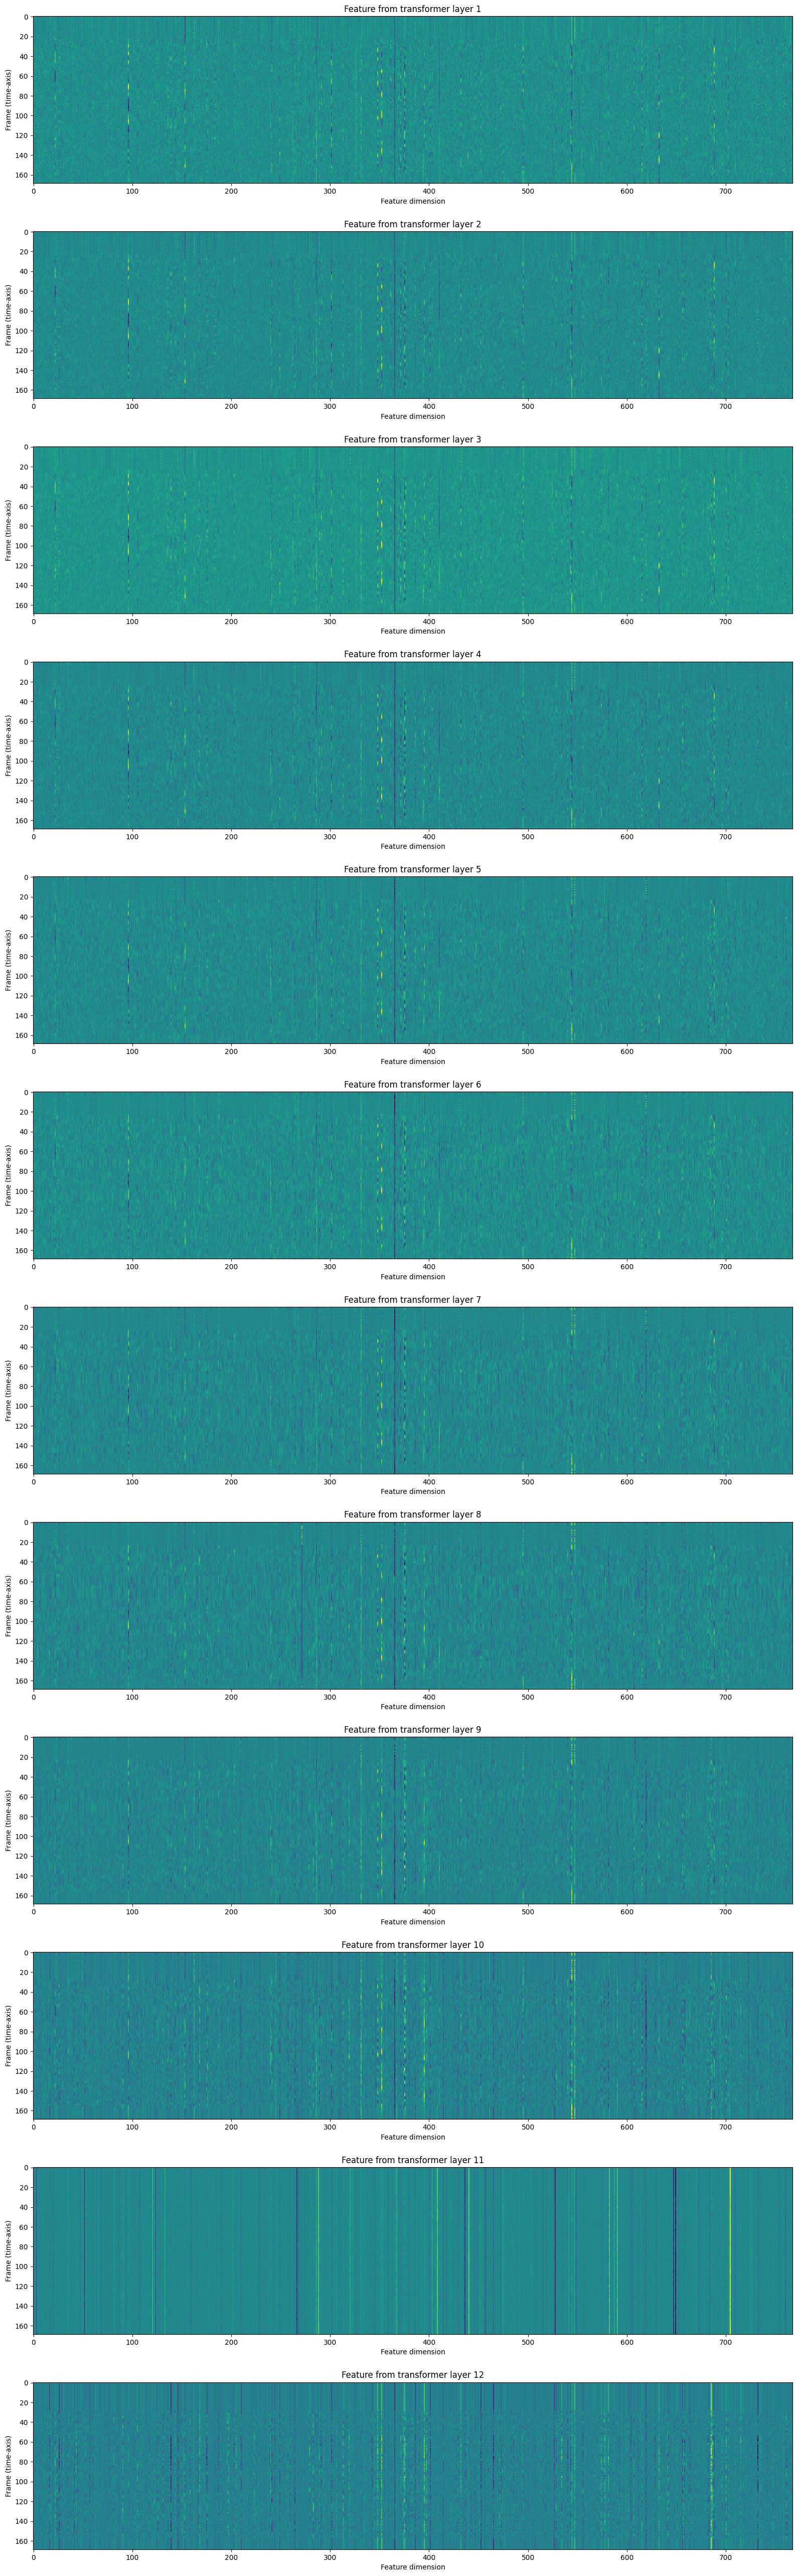

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


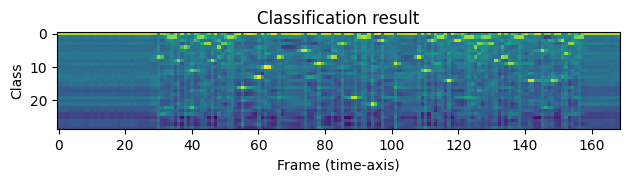

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
